# ОИАД. Лабораторная работа №3

https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

In [28]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [29]:
print("\nПропуски по колонкам:")
print(df.isnull().sum())
print("\nОписательная статистика (числовые признаки):")
print(df.describe())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nЧисловые признаки:", numeric_cols)

def detect_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper), lower, upper

print("\nВыбросы (IQR) для числовых признаков:")
outlier_summary = {}
for c in numeric_cols:
    mask, lo, hi = detect_outliers_iqr(df[c])
    n = mask.sum()
    outlier_summary[c] = {'n_outliers': int(n), 'lower': float(lo), 'upper': float(hi)}
    print(f"  {c}: {n} выбросов; границы [{lo:.2f}, {hi:.2f}]")


Пропуски по колонкам:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Описательная статистика (числовые признаки):
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Числовые признаки: ['age', 'bmi', 'children', 'charges']

Выбросы (IQR) для числовых признаков:
  age: 0 выбросов; границы [-9.00, 87.00]
  bmi: 9 выбросов; границы [13.70, 47.29]
  children: 0 выбросов; границы [-3.00, 5.00]
  charges: 139 выбросов; границы [-13109.15, 34489.35]


In [30]:
df_enc = df_cap.copy()
df_enc['sex_male'] = (df_enc['sex'] == 'male').astype(int)
df_enc['smoker_yes'] = (df_enc['smoker'] == 'yes').astype(int)

df_enc = pd.concat([df_enc.drop(columns=['region','sex','smoker']),
                    pd.get_dummies(df_cap['region'], prefix='region', drop_first=True)],
                   axis=1)
df_enc.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,False,False,True
1,18,33.770,1,1725.55230,1,0,False,True,False
2,28,33.000,3,4449.46200,1,0,False,True,False
3,33,22.705,0,21984.47061,1,0,True,False,False
4,32,28.880,0,3866.85520,1,0,True,False,False


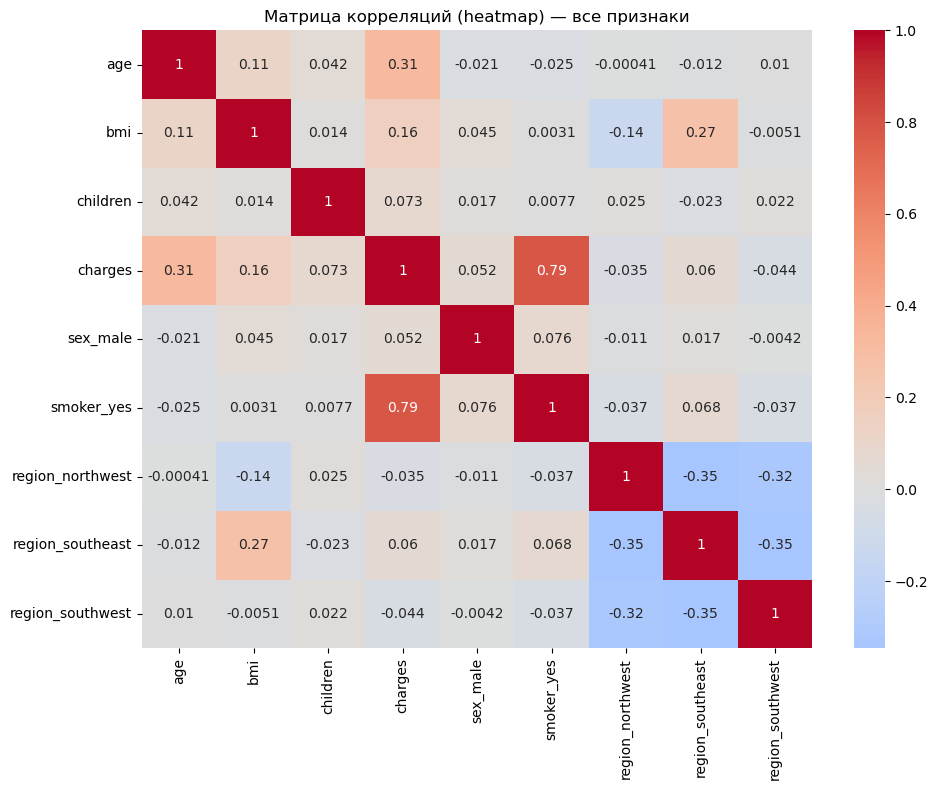

In [31]:
corr_matrix = df_enc.corr()

plt.figure(figsize=(10,8))
plt.title("Матрица корреляций (heatmap) — все признаки")
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.tight_layout()
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)


In [69]:
X = df_enc.drop('charges', axis=1)
y = df_enc['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

In [70]:
# Аналитическое решение (нормальное уравнение)
w_analytic = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

y_pred_analytic = X_test_bias @ w_analytic
mse_analytic = mean_squared_error(y_test, y_pred_analytic)
print("\nВеса (аналитически):",w_analytic)
print("MSE (аналитически):", mse_analytic)


Веса (аналитически): [12566.86561618  3185.03901222  1377.16399747   464.55070506
   -63.903919    8017.68510992  -156.28789253  -278.25126339
  -332.73876867]
MSE (аналитически): 23437328.291634925


In [71]:
# Численное решение (градиентный спуск)
def gradient_descent(X, y, lr=0.01, epochs=5000):
    m, n = X.shape
    w = np.random.randn(n)
    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        grad = (2/m) * X.T @ error
        w -= lr * grad
    return w

w_gd = gradient_descent(X_train_bias, y_train, lr=0.01, epochs=5000)
y_pred_gd = X_test_bias @ w_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
print("\nВеса (град. спуск):",w_gd)
print("MSE (град. спуск):", mse_gd)


Веса (град. спуск): [12566.86561618  3185.03901222  1377.16399747   464.55070506
   -63.903919    8017.68510992  -156.28789253  -278.25126339
  -332.73876867]
MSE (град. спуск): 23437328.291634884


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

In [73]:
def ridge_analytic(X, y, lam=1.0):
    I = np.eye(X.shape[1])
    I[0, 0] = 0  # не регуляризуем bias
    return np.linalg.inv(X.T @ X + lam * I) @ X.T @ y

w_ridge_analytic = ridge_analytic(X_train_bias, y_train, lam=10.0)
y_pred_ridge_analytic = X_test_bias @ w_ridge_analytic
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge_analytic)
print("\nВеса (Ridge anal.):",w_ridge_analytic)
print("MSE (Ridge anal.):", mse_ridge_analytic)


Веса (Ridge anal.): [12566.86561618  3153.12199769  1365.20426443   463.27414961
   -57.8883337   7941.0942855   -151.40741443  -265.15973502
  -325.29263358]
MSE (Ridge anal.): 23502184.37763966


In [78]:
# Численное решение (градиентный спуск с регуляризацией)
def ridge_gd(X, y, lam=1.0, lr=0.01, epochs=5000):
    m, n = X.shape
    w = np.random.randn(n)
    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        grad = (2/m) * X.T @ error + 2 * lam * w
        grad[0] = (2/m) * X[:, 0] @ error  # bias без регуляризации
        w -= lr * grad
    return w

w_ridge_gd = ridge_gd(X_train_bias, y_train, lam=10.0)
y_pred_ridge_gd = X_test_bias @ w_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
print("\nВеса (Ridge GD):",w_ridge_gd)
print("MSE (Ridge GD):", mse_ridge_gd)


Веса (Ridge GD): [12566.86561618   270.40779455   148.88898826    67.48261732
    41.591438     714.39931849   -23.86678857    44.9370009
   -31.45877782]
MSE (Ridge GD): 94452827.2682481


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [81]:
mean_train = float(y_train.mean())
y_pred_test_baseline = np.full_like(y_test, fill_value=mean_train)
mse_baseline = mean_squared_error(y_test, y_pred_test_baseline)

mse_analytic_reg = mse_ridge_analytic
mse_gd_reg = mse_ridge_gd

print("\nСравнение MSE на тестовой выборке:")
print(f"  1) Константная (mean) MSE: {mse_baseline:.4f}")
print(f"  2) Аналитическая (без рег.) MSE: {mse_analytic:.4f}")
print(f"  3) GD (без рег.) MSE: {mse_gd:.4f}")
print(f"  4a) Аналитическая с L2 (lambda={lamb}) MSE: {mse_analytic_reg:.4f}")
print(f"  4b) GD с L2 (lambda={lamb}) MSE: {mse_gd_reg:.4f}")

# Выведем таблицу результатов
results = pd.DataFrame({
    'model': ['baseline_mean', 'analytic', 'gd', f'analytic_l2_{lamb}', f'gd_l2_{lamb}'],
    'mse_test': [mse_baseline, mse_analytic, mse_gd, mse_analytic_reg, mse_gd_reg]
})
print("\nРезультаты в таблице:")
print(results.sort_values('mse_test'))

# ---------------------------
# Дополнительно: подбор lambda (регуляризации) по сетке (простая валидация)
# ---------------------------
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
scores = []
for lam in lambdas:
    w_a = normal_equation(X_train_b, y_train, l2_lambda=lam)
    mse = mean_squared_error(y_test, X_test_b.dot(w_a))
    scores.append({'lambda': lam, 'mse_test': mse})
scores_df = pd.DataFrame(scores).sort_values('mse_test')
print("\nПодбор lambda (аналитически) — результаты:")
print(scores_df)


Сравнение MSE на тестовой выборке:
  1) Константная (mean) MSE: 108747335.0114
  2) Аналитическая (без рег.) MSE: 23437328.2916
  3) GD (без рег.) MSE: 23437328.2916
  4a) Аналитическая с L2 (lambda=10.0) MSE: 23502184.3776
  4b) GD с L2 (lambda=10.0) MSE: 94452827.2682

Результаты в таблице:
              model      mse_test
1          analytic  2.343733e+07
2                gd  2.343733e+07
3  analytic_l2_10.0  2.350218e+07
4        gd_l2_10.0  9.445283e+07
0     baseline_mean  1.087473e+08

Подбор lambda (аналитически) — результаты:
   lambda      mse_test
0    0.00  2.343733e+07
1    0.01  2.343739e+07
2    0.10  2.343791e+07
3    1.00  2.344323e+07
4   10.00  2.350218e+07
5  100.00  2.457078e+07


- Все методы показали далеко не лучшие результаты
- Наилучшие результаты у регрессии рассчитаны аналитически и численно
- Регуляризация только ухудшила значение ошибки
- Средним считать все еще хуже